### Init MLRun and Kedro

In [1]:
import mlrun
from kedro.io import DataCatalog
from kedro.framework.session import KedroSession
from kedro.framework.startup import bootstrap_project
from pathlib import Path

### Setup MLRun Project

In [2]:
project = mlrun.get_or_create_project(name="kedro-spaceflights", context="./")

> 2022-10-25 22:53:20,713 [info] loaded project kedro-spaceflights from MLRun DB


In [3]:
data_processing_fn = project.set_function(name="dp", func="src/spaceflights/pipelines/data_processing/nodes.py", kind="job", image="mlrun/mlrun")
data_science_fn = project.set_function(name="ds", func="src/spaceflights/pipelines/data_science/nodes.py", kind="job", image="mlrun/mlrun")
serving_fn = project.set_function(name="serving", func="hub://v2_model_server")

In [4]:
project.set_workflow(name="data_pipeline", workflow_path="pipeline.py")

In [5]:
project.save()

<mlrun.projects.project.MlrunProject object at 0x7fef61297750>

### Run Training and Deployment Pipeline

Pipeline running (id=5d10c583-f450-442c-a5f0-a908b4fa2075), click here to view the details in MLRun UI

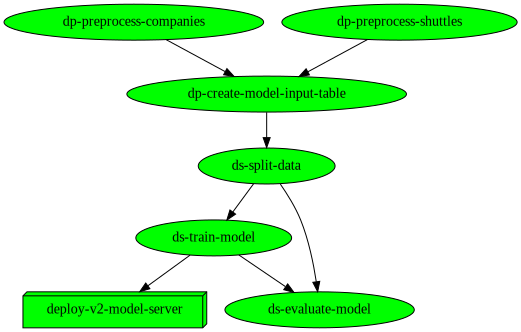

uid,start,state,name,parameters,results
...0905d429,Oct 25 22:56:06,completed,ds-evaluate_model,,
...7c7b0936,Oct 25 22:55:29,completed,ds-train_model,,
...d8b9663c,Oct 25 22:54:52,completed,ds-split_data,"parameters={'test_size': 0.2, 'random_state': 3, 'features': ['engines', 'passenger_capacity', 'crew', 'd_check_complete', 'moon_clearance_complete', 'iata_approved', 'company_rating', 'review_scores_rating']}",
...c1d0b7c4,Oct 25 22:54:16,completed,dp-create_model_input_table,,
...a62bfc66,Oct 25 22:53:49,completed,dp-preprocess_shuttles,,
...85be9eb0,Oct 25 22:53:49,completed,dp-preprocess_companies,,


In [6]:
def get_path_from_catalog(catalog: DataCatalog, key: str) -> str:
    return str(catalog._data_sets.get(key)._filepath)

metadata = bootstrap_project(Path.cwd())
with KedroSession.create(metadata.package_name) as session:
    context = session.load_context()
    catalog = context.catalog
    
    project.run(
        name="data_pipeline",
        arguments={
            "companies_path" : get_path_from_catalog(catalog, "companies"),
            "shuttles_path" : get_path_from_catalog(catalog, "shuttles"),
            "reviews_path" : get_path_from_catalog(catalog, "reviews"),
            "parameters" : catalog.load("params:data_science.active_modelling_pipeline.model_options")
        },
        watch=True
    )

### Predict via Deployed Model

In [7]:
X_test = project.get_artifact("ds-split_data_X_test").to_dataitem().as_df().head()
X_test

,engines,passenger_capacity,crew,d_check_complete,moon_clearance_complete,iata_approved,company_rating,review_scores_rating
656795,4.0,10,6.0,True,False,False,1.00,100.0
1442561,3.0,6,5.0,False,False,True,0.93,100.0
924116,2.0,5,3.0,True,False,False,1.00,93.0
701563,4.0,8,4.0,True,False,False,1.00,100.0
1464436,2.0,4,2.0,False,False,False,1.00,100.0


In [8]:
records = X_test.to_dict(orient="split")["data"]
records

[
    [4.0, 10, 6.0, True, False, False, 1.0, 100.0],
    [3.0, 6, 5.0, False, False, True, 0.93, 100.0],
    [2.0, 5, 3.0, True, False, False, 1.0, 93.0],
    [4.0, 8, 4.0, True, False, False, 1.0, 100.0],
    [2.0, 4, 2.0, False, False, False, 1.0, 100.0]
]

In [9]:
serving_fn.invoke("/v2/models/regressor/predict", body={"inputs" : records})

> 2022-10-25 22:57:30,387 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-kedro-spaceflights-v2-model-server.default-tenant.svc.cluster.local:8080/v2/models/regressor/predict'}


{
    'id': 'f7d7c714-2b57-42e8-ad85-c2b1158b3e80',
    'model_name': 'regressor',
    'outputs': [
        [5788.977750924654],
        [3973.5655208766825],
        [3594.495141292972],
        [5471.549652762642],
        [3400.577384100903]
    ]
}